**NB:** Precomputed predictions can be found in the Excel file `./data/precomputed_predictions.xlsx`

In [1]:
import os, pickle, glob, csv
import numpy as np
import prody as pd
import rhapsody as rd

# Analysis of human ROMK variants
Since the structure of human ROMK has not been resolved yet, we will use a homology model from SWISS-MODEL.

In [2]:
from prody import *

pdb_path = 'data/ROMK_homology_model.pdb'
pdb = pd.parsePDB(pdb_path).select('protein')

print(pdb['A'].getResnums())
pdb.getHierView()

@> 10528 atoms and 1 coordinate set(s) were parsed in 0.13s.


[ 38  38  38 ... 365 365 365]


<HierView: Selection 'protein' (4 chains, 1312 residues)>

## RHAPSODY predictions
We will compute predictions with different environment models and with/without EVmutation feature included in the classifier.

In [3]:
all_preds = {}

if os.path.isfile('local/all_preds.pkl'):
    all_preds = pickle.load(open('local/all_preds.pkl', 'rb'))
    print('Precomputed predictions imported.')
else:
    if not os.path.isdir('local'):
        os.mkdir('local')
    for mode in ['classic', 'EVmutation']:
        for env in ['chain', 'reduced', 'sliced']:
            case = f'{mode}-{env}'
            folder = os.path.join('local', case)
            if os.path.isdir(folder):
                pickle_file = os.path.join(folder, 'rhapsody-pickle.pkl')
                all_preds[case] = pickle.load(open(pickle_file, 'rb'))
                continue
            os.mkdir(folder)
            # run rhapsody
            if mode == 'classic':
                rh = rd.rhapsody('data/pph2-full.txt', query_type='PolyPhen2', 
                                 custom_PDB=pdb, force_env=env)
            else:
                rh = rd.rhapsody('data/pph2-full.txt', query_type='PolyPhen2', 
                                 main_classifier=rd.getDefaultClassifiers()['EVmut'],
                                 custom_PDB=pdb, force_env=env)
            # store files
            all_preds[case] = rh
            for f in glob.glob('rhapsody-*.*'):
                os.rename(f, os.path.join(folder, f))
    pickle.dump(all_preds, open('local/all_preds.pkl', 'wb'))

Precomputed predictions imported.


In [4]:
rh = all_preds['classic-sliced']

# print saturation mutagenesis table
rd.print_sat_mutagen_figure('local/sat_mutagen-1', rh, fig_width=26, res_interval=(37, 202))
rd.print_sat_mutagen_figure('local/sat_mutagen-2', rh, fig_width=26, res_interval=(202, 367))

# print residue-averaged predictions on PDB structure
mappedPDBs = rh.writePDBs(filename_prefix='local/rhapsody-PDB')

@> Saturation mutagenesis figure saved to local/sat_mutagen-1.png
@> Saturation mutagenesis figure saved to local/sat_mutagen-2.png
@> Predictions written to PDB file local/rhapsody-PDB_custom.pdb


## Comparison with experimental results

In [5]:
rh_ref_classic = all_preds['classic-sliced']
rh_ref_EVmut = all_preds['EVmutation-sliced']

In [6]:
reader = csv.reader(open('data/experimental_results.csv'))

exp_map = {'-1': 'GOF', '0': 'NEU', '1': 'INT', '2': 'DEL'}
class_map = {'neutral': 'neu', 'prob.neutral': 'p.n', '?': '?',
             'deleterious': 'del', 'prob.delet.': 'p.d'}
case_map = {'classic-chain': 'ch', 'classic-reduced': 'rd', 'classic-sliced': 'sl', 
            'EVmutation-chain': 'EVch', 'EVmutation-reduced': 'EVrd', 'EVmutation-sliced': 'EVsl'}

fields = []

cases = all_preds.keys()
print(' '*45, ''.join([f'{case_map[c]:6}' for c in cases]), 'EVmut PP2')

for i,l in enumerate(reader):
    if i==0:
        continue
    SAV = 'P48048 ' + l[0]
    oSAV = 'P48048 ' + l[1] if l[1] else SAV
    exp_fitness = exp_map[l[2]]
    group = l[3]
    pred_class = l[4]
    s = f'({l[1][-3:]:3})' if l[1] else ' -'
    print(f'{SAV:15} {s:5} {exp_fitness}  {group} {pred_class:15}  ', end='')
    for case in cases:
        rh = all_preds[case]
        pclass = rh.getPredictions(SAV=oSAV)['path. class']
        pclass = class_map[pclass]
        print(f'{pclass:3}', end='   ')
        
    ref_classic_preds = rh_ref_classic.getPredictions(SAV=oSAV)
    path_prob = ref_classic_preds['path. prob.']
    EVmut_score = ref_classic_preds['EVmutation score']
    EVmut_class = ref_classic_preds['EVmutation path. class']
    PP2_score = ref_classic_preds['PolyPhen-2 score']
    PP2_class = ref_classic_preds['PolyPhen-2 path. class']
    
    print(f' {EVmut_class[:3]:3}   {PP2_class[:3]:3}')
    
    ref_EVmut_preds = rh_ref_EVmut.getPredictions(SAV=oSAV)
    path_prob_EVmut = ref_EVmut_preds['path. prob.']
    
    fields.append( (SAV, oSAV, group, exp_fitness, path_prob, path_prob_EVmut, EVmut_score, PP2_score) )

                                              ch    rd    sl    EVch  EVrd  EVsl   EVmut PP2
P48048 140 V M   -    GOF  0 pos_control      neu   del   del   neu   neu   neu    neu   del
P48048 80 K M    -    GOF  0 pos_control      neu   del   del   neu   neu   neu    neu   del
P48048 342 H S   -    INT  1 GOF              neu   neu   neu   neu   neu   neu    neu   neu
P48048 65 F L    -    NEU  1 GOF              neu   neu   neu   neu   neu   neu    neu   neu
P48048 86 T A    -    NEU  1 GOF              neu   neu   neu   neu   neu   neu    neu   neu
P48048 154 A P   -    DEL  1 GOF              neu   neu   neu   neu   neu   neu    neu   neu
P48048 94 F L    -    NEU  1 GOF              neu   neu   neu   neu   neu   neu    neu   neu
P48048 358 C Q   -    DEL  2 del_novel        del   del   del   ?     ?     ?      ?     del
P48048 355 C Q   -    DEL  2 del_novel        del   del   del   ?     ?     ?      ?     del
P48048 361 N C   -    INT  2 del_novel        del   del   del   ?     

In [7]:
dt = np.dtype([('SAV', 'U15'), ('oSAV', 'U15'), ('group', 'i'), 
               ('exp_fitness', 'U15'), 
               ('rhapsody_pprob', 'f8'), ('rhapsody_pprob-EVmut', 'f8'),
               ('EVmut_score', 'f8'), ('PP2_score', 'f8')])
exp_SAVs = np.array(fields, dtype=dt)
exp_SAVs = exp_SAVs[np.argsort(-exp_SAVs['rhapsody_pprob'])]

## Figures

In [8]:
EVmut_cutoff = -rd.getSettings(print=False)['EVmutation_metrics']['optimal cutoff']

In [9]:
# positive control SAVs
CTRL_SAVs = np.array([(s['EVmut_score'], s['rhapsody_pprob'], s['rhapsody_pprob-EVmut']) 
                      for s in exp_SAVs[exp_SAVs['group']==0]])

# SAVs with both Rhapsody and EVmutation predictions
subset = exp_SAVs[~np.isnan(exp_SAVs['EVmut_score'])]
subset = subset[subset['group']!=0]
DEL_SAVs = np.array([(s['EVmut_score'], s['rhapsody_pprob'], s['rhapsody_pprob-EVmut']) 
                     for s in subset if s['exp_fitness']=='DEL'])
INT_SAVs = np.array([(s['EVmut_score'], s['rhapsody_pprob'], s['rhapsody_pprob-EVmut']) 
                     for s in subset if s['exp_fitness']=='INT'])
NEU_SAVs = np.array([(s['EVmut_score'], s['rhapsody_pprob'], s['rhapsody_pprob-EVmut']) 
                     for s in subset if s['exp_fitness']=='NEU'])

# SAVs without EVmutation predictions
subset = exp_SAVs[np.isnan(exp_SAVs['EVmut_score'])]
subset = subset[subset['group']!=0]
DEL_SAVs_rh = np.array([(s['PP2_score'], s['rhapsody_pprob']) 
                        for s in subset if s['exp_fitness']=='DEL'])
INT_SAVs_rh = np.array([(s['PP2_score'], s['rhapsody_pprob']) 
                        for s in subset if s['exp_fitness']=='INT'])
NEU_SAVs_rh = np.array([(s['PP2_score'], s['rhapsody_pprob']) 
                        for s in subset if s['exp_fitness']=='NEU'])
GOF_SAVs_rh = np.array([(s['PP2_score'], s['rhapsody_pprob']) 
                        for s in subset if s['exp_fitness']=='GOF'])

# all "novel" Rhapsody predictions (i.e. without EVmutation score)
preds = rh_ref_classic.getPredictions()
subset = preds[np.isnan(preds['EVmutation score'])]
all_SAVs_rh = np.array([(s['PolyPhen-2 score'], s['path. prob.'])
                        for s in subset if s['SAV coords'] not in exp_SAVs['oSAV']])

In [10]:
EVmut_score = rh_ref_classic.getPredictions()['EVmutation score']
PP2_score = rh_ref_classic.getPredictions()['PolyPhen-2 score']
rhapsody_pprob = rh_ref_classic.getPredictions()['path. prob.']

from scipy.stats import spearmanr

sel = ~np.isnan(EVmut_score)
rho_EVm = spearmanr(rhapsody_pprob[sel], EVmut_score[sel])

sel = ~np.isnan(rhapsody_pprob)
rho_PP2 = spearmanr(rhapsody_pprob[sel], PP2_score[sel])

print(f'Spearman corr. with EVmutation: {rho_EVm[0]:5.3f}')
print(f'Spearman corr. with PolyPhen-2: {rho_PP2[0]:5.3f}')

Spearman corr. with EVmutation: -0.668
Spearman corr. with PolyPhen-2: 0.779


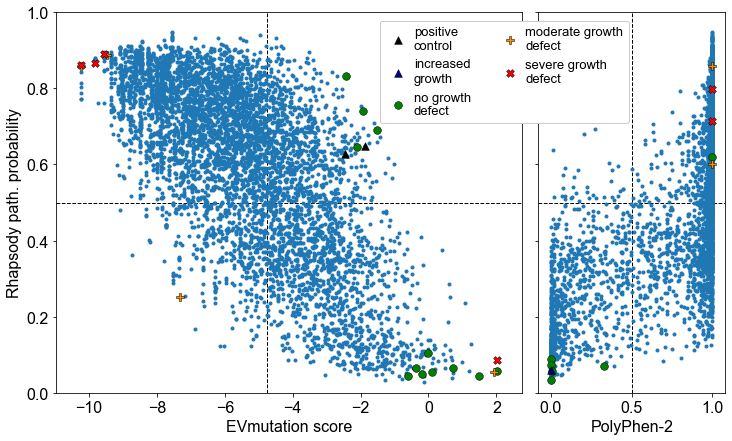

In [11]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

fig, axes = plt.subplots(1, 2, figsize=(12,7), gridspec_kw={'width_ratios': [10, 4]})
plt.subplots_adjust(wspace=0.05)

ax1, ax2 = axes
ax1.scatter(EVmut_score, rhapsody_pprob, marker='.')
ax1.axvline(EVmut_cutoff, color='k', linestyle='--', lw=1, zorder=0)
ax1.axhline(0.5, color='k', linestyle='--', lw=1, zorder=0)

ax1.set_ylim((0,1))
ax1.set_xlabel('EVmutation score')
ax1.set_ylabel('Rhapsody path. probability')

ax1.scatter(CTRL_SAVs[:,0], CTRL_SAVs[:,1], s=60, color='k',  marker='^', label='positive\ncontrol',
            linewidths=.5, edgecolors='k')
ax1.scatter(NEU_SAVs[:,0], NEU_SAVs[:,1], s=60, color='green',  marker='o', label='no growth\ndefect',
            linewidths=.5, edgecolors='k')
ax1.scatter(INT_SAVs[:,0], INT_SAVs[:,1], s=80, color='darkorange', marker='P', label='moderate growth\ndefect',
            linewidths=.5, edgecolors='k')
ax1.scatter(DEL_SAVs[:,0], DEL_SAVs[:,1], s=60, color='red',    marker='X', label='severe growth\ndefect',
            linewidths=.5, edgecolors='k')

ax2.set_ylim((0,1))
# ax2.set_xlim((-.1,1.1))
ax2.set_xlabel('PolyPhen-2')
ax2.set_yticklabels([])

ax2.axhline(0.5, color='k', linestyle='--', lw=1, zorder=0)
ax2.axvline(0.5, color='k', linestyle='--', lw=1, zorder=0)
# ax2.scatter(all_SAVs_rh[:,0], all_SAVs_rh[:,1], marker='.')  # only SAVs with no EVmut. predictions
ax2.scatter(PP2_score, rhapsody_pprob, marker='.')
ax2.scatter(NEU_SAVs_rh[:,0], NEU_SAVs_rh[:,1], s=60, color='green', marker='o', label='NEU',
            linewidths=.5, edgecolors='k')
ax2.scatter(GOF_SAVs_rh[:,0], GOF_SAVs_rh[:,1], s=60, color='navy', marker='^', label='increased\ngrowth',
            linewidths=.5, edgecolors='k')
ax2.scatter(INT_SAVs_rh[:,0], INT_SAVs_rh[:,1], s=80, color='darkorange', marker='P', label='INT',
            linewidths=.5, edgecolors='k')
ax2.scatter(DEL_SAVs_rh[:,0], DEL_SAVs_rh[:,1], s=60, color='red', marker='X', label='DEL',
            linewidths=.5, edgecolors='k')

handles = ax1.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1]
handles.insert(1, ax2.get_legend_handles_labels()[0][1])
labels.insert(1, ax2.get_legend_handles_labels()[1][1])
ax1.set_zorder(1)
ax1.legend(handles, labels, fontsize=13, handletextpad=0.2, ncol=2, loc=(0.695, 0.71), framealpha=1.0)

plt.savefig('local/scatter_plot-classic.png', dpi=300)

In [12]:
EVmut_score = rh_ref_EVmut.getPredictions()['EVmutation score']
rhapsody_pprob = rh_ref_EVmut.getPredictions()['path. prob.']

from scipy.stats import spearmanr

sel = ~np.isnan(rhapsody_pprob)
rho = spearmanr(rhapsody_pprob[sel], EVmut_score[sel])

print(f'Spearman corr. Rhapsody+EVmut. vs EVmutation: {rho[0]:5.3f}')

Spearman corr. Rhapsody+EVmut. vs EVmutation: -0.861


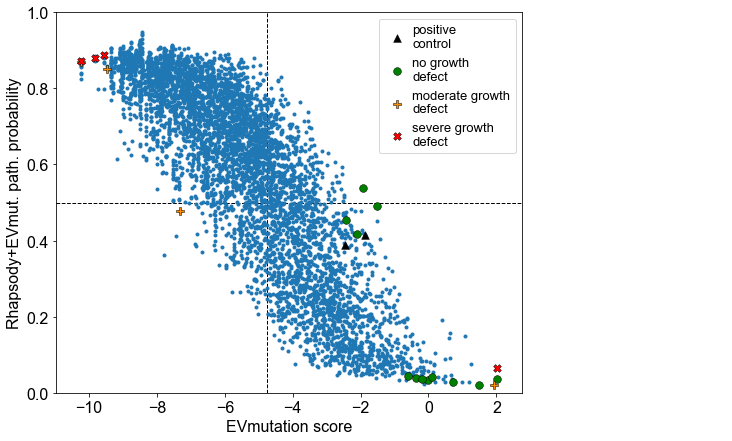

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

fig, axes = plt.subplots(1, 2, figsize=(12,7), gridspec_kw={'width_ratios': [10, 4]})
plt.subplots_adjust(wspace=0.05)

ax1, ax2 = axes
ax1.scatter(EVmut_score, rhapsody_pprob, marker='.')
ax1.axvline(EVmut_cutoff, color='k', linestyle='--', lw=1, zorder=0)
ax1.axhline(0.5, color='k', linestyle='--', lw=1, zorder=0)

ax1.set_ylim((0,1))
ax1.set_xlabel('EVmutation score')
ax1.set_ylabel('Rhapsody+EVmut. path. probability')

ax1.scatter(CTRL_SAVs[:,0], CTRL_SAVs[:,2], s=60, color='k',  marker='^', label='positive\ncontrol',
            linewidths=.5, edgecolors='k')
ax1.scatter(NEU_SAVs[:,0], NEU_SAVs[:,2], s=60, color='green',  marker='o', label='no growth\ndefect',
            linewidths=.5, edgecolors='k')
ax1.scatter(INT_SAVs[:,0], INT_SAVs[:,2], s=80, color='darkorange', marker='P', label='moderate growth\ndefect',
            linewidths=.5, edgecolors='k')
ax1.scatter(DEL_SAVs[:,0], DEL_SAVs[:,2], s=60, color='red',    marker='X', label='severe growth\ndefect',
            linewidths=.5, edgecolors='k')

ax1.legend(fontsize=13, handletextpad=0.2)

ax2.axis('off')

plt.savefig('local/scatter_plot-EVmut.png', dpi=300)

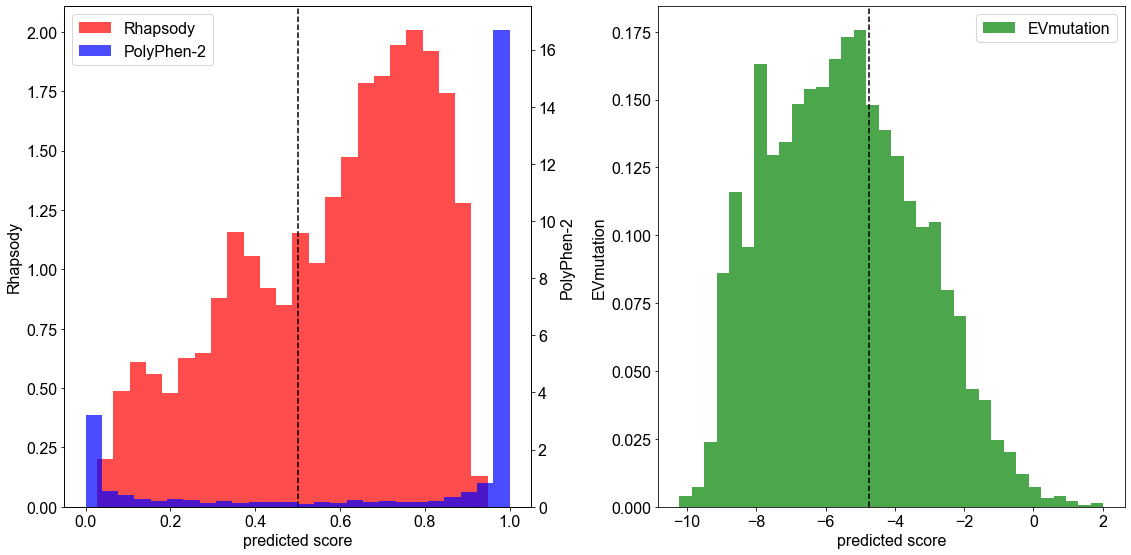

In [14]:
EVmut_score = rh_ref_classic.getPredictions()['EVmutation score']
EVmut_score = EVmut_score[~np.isnan(EVmut_score)]
rhapsody_pprob = rh_ref_classic.getPredictions()['path. prob.']
rhapsody_pprob = rhapsody_pprob[~np.isnan(rhapsody_pprob)]
PP2_score = rh_ref_classic.getPredictions()['PolyPhen-2 score']

fig, axes = plt.subplots(1, 2, figsize=(16,8))

ax = axes[0]
ax2 = ax.twinx()
ax.hist(rhapsody_pprob, density=True, bins='auto', color='red', alpha=.7, label='Rhapsody')
ax2.hist(PP2_score, density=True, bins='auto', color='blue', alpha=.7, label='PolyPhen-2')
ax.axvline(x=.5, ls='--', color='k')
ax.set_xlabel('predicted score')
ax.set_ylabel('Rhapsody')
ax2.set_ylabel('PolyPhen-2')

handles = ax.get_legend_handles_labels()[0]
labels = ax.get_legend_handles_labels()[1]
handles.extend(ax2.get_legend_handles_labels()[0])
labels.extend(ax2.get_legend_handles_labels()[1])
ax.legend(handles, labels)

axr = axes[1]
axr.hist(EVmut_score, density=True, bins='auto', color='green', alpha=.7, label='EVmutation')
axr.set_ylabel('EVmutation')
axr.set_xlabel('predicted score')
axr.axvline(x=EVmut_cutoff, ls='--', color='k')
axr.legend()

fig.tight_layout()
fig.savefig('local/distributions.png', dpi=300)

/home/luca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


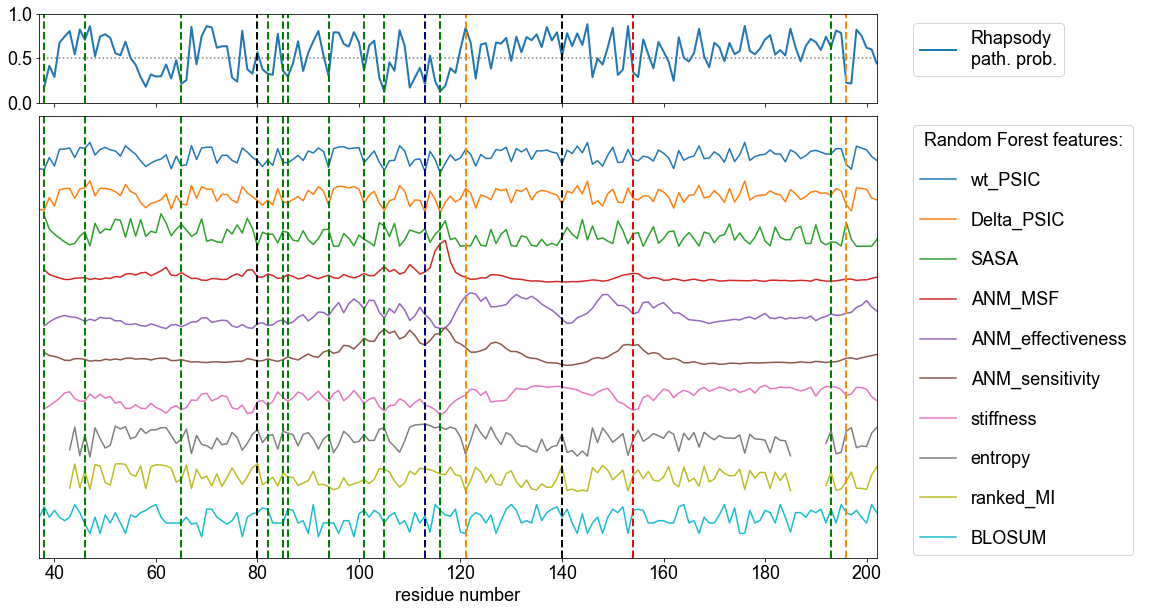

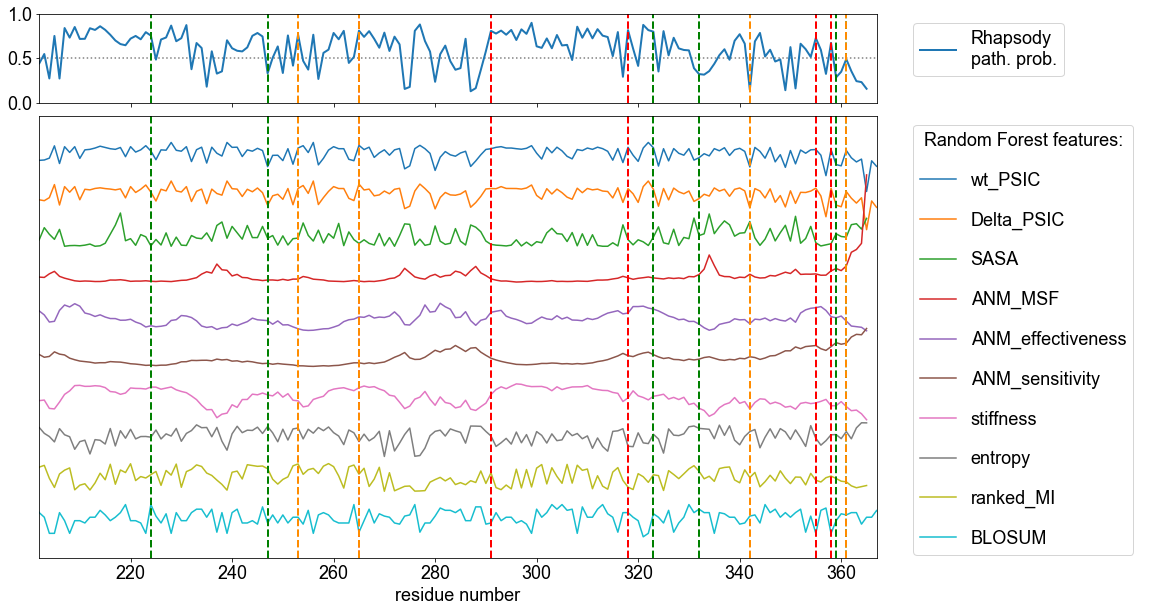

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18, 'font.family': 'Arial'})

seq_pos = rh_ref_classic.getUniqueSAVcoords()['position']
seq_pos = seq_pos.reshape((-1, 19))
seq_pos = seq_pos[:,0]

resavg_pprob = rh_ref_classic.getResAvgPredictions()['path. prob.']

for rng in [(37,202), (202, 367)]:
    fig, axes = plt.subplots(2, 2, figsize=(20,10), 
                             gridspec_kw={'width_ratios': [10, 3], 'height_ratios': [2, 10]})
    plt.subplots_adjust(wspace=0.05)
    plt.subplots_adjust(hspace=0.05)

    ax_pp = axes[0,0]
    axes[0,1].axis('off')
    ax = axes[1,0]
    ax_leg = axes[1,1]
    ax_leg.axis('off')

    ax_pp.axhline(y=.5, color='gray', ls=':', zorder=0)
    ax_pp.plot(seq_pos, resavg_pprob, lw=2, label='Rhapsody\npath. prob.')
    ax_pp.set_xlim(rng)
    ax_pp.set_ylim((0, 1))
    ax_pp.set_xticklabels([])
    handles = ax_pp.get_legend_handles_labels()[0]
    labels = ax_pp.get_legend_handles_labels()[1]
    axes[0,1].legend(handles, labels, loc='upper left')

    for i,f in enumerate(rh_ref_classic.featSet):
        f_arr = rh_ref_classic.featMatrix[:,i]
        # residue-average
        f_mtx = f_arr.reshape((-1, 19))
        f_resavg = np.nanmean(f_mtx, axis=1)
        # normalize
        f_resavg -= np.nanmean(f_resavg)
        f_resavg /= 5*np.nanstd(f_resavg)
        # plot
        ax.plot(seq_pos, f_resavg + 9 - i, label=f.replace('-sliced', ''))

    ax.set_ylim((-1, 10))
    ax.set_xlim(rng)
    ax.set_xlabel('residue number')
    ax.set_yticks([])

    handles = ax.get_legend_handles_labels()[0]
    labels = ax.get_legend_handles_labels()[1]
    ax_leg.legend(handles, labels, title="Random Forest features:",
                  loc='upper left', labelspacing=1.2)

    for s in exp_SAVs:
        pos = int(s['oSAV'].split()[1])
        phenotype = s['exp_fitness']
        if phenotype == 'GOF':
            if s['group'] == 0:
                color = 'black'
            else:
                color = 'navy'
        elif phenotype == 'NEU':
            color = 'green'
        elif phenotype == 'INT':
            color = 'darkorange'
        else:
            assert phenotype == 'DEL'
            color = 'red'
        ax_pp.axvline(x=pos, ls='--', lw=2, color=color)
        ax.axvline(x=pos, ls='--', lw=2, color=color)

    plt.savefig('local/features-{}_{}.png'.format(*rng), dpi=300)